In [ ]:
!pip install --quiet norse 
!pip install --quiet torch
!pip install --quiet torchvision

     |████████████████████████████████| 92kB 5.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
% cd "/content/drive/MyDrive/Norse SNN/Speach/"
% ls

/content/drive/MyDrive/Norse SNN/Speach
 checkpoints/
'CNN Russian_Speach_Digit_0-9.ipynb'
'code 3conv zeros.ipynb'
'code Russian digit 99 %.ipynb'
'code Speech command comm.ipynb'
'code Speech command digits.ipynb'
'code Speech TIMIT phoneme.ipynb'
'code Speech TIMIT spec phoneme.ipynb'
'code Speech TIMIT words.ipynb'
 data/
 NB/
'Quant code Speech commands digits.ipynb'
'Quant code Speech Russian digits.ipynb'
'Quant code Speech TIMIT words.ipynb'
'Копия code 3conv zeros.ipynb'
'Копия code.ipynb'


In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, random_split


import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms


import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

#norse
import norse
from norse.torch        import LIFCell, LILinearCell  
from norse.torch.module import LILinearCell, LIFParameters, LIState, LIFFeedForwardState, SequentialState, LICell

from norse.torch.module.encode  import ConstantCurrentLIFEncoder, PoissonEncoder, SpikeLatencyLIFEncoder


from typing import NamedTuple


In [ ]:
BATCH_SIZE = 32
T = 48
LR = 0.001

RAND_SEED=0

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('select device:', DEVICE)

select device: cuda


## Dataset


### transforms

In [ ]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.13,), (0.2,)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.13,), (0.2,)),
])

### CIFAR10

In [ ]:
def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

def print_CIFAR10(train_loader):

    images, labels = iter(train_loader).next()


    images1, labels1 = images[:3], labels[:3]
    images2, labels2 = images[3:6], labels[3:6]

    fig, axes = plt.subplots(1, len(images1), figsize=(12,12))
    for idx, image in enumerate(images1):
        axes[idx].imshow(convert_to_imshow_format(image))
        axes[idx].set_title(classes[labels1[idx]])
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])

    fig, axes = plt.subplots(1, len(images2), figsize=(12,12))
    for idx, image in enumerate(images2):
        axes[idx].imshow(convert_to_imshow_format(image))
        axes[idx].set_title(classes[labels2[idx]])
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])   


### Data loader

In [ ]:
def load_split_train_test(datadir = "./data/Russian_Speach_Digit_0-9 (spec, low)", valid_size = .2, batch_size=BATCH_SIZE):
    print('batch_size', batch_size)

    model_dataset = ImageFolder(datadir, 
                                transform= transforms.Compose([
                                                       transforms.Resize((64,28)),
                                                       transforms.ToTensor(),
                                                       transforms.Normalize((0.13,), (0.3,)),
                                                     ])) 

    total_size = len(model_dataset)
    test_size  = int(valid_size*total_size)


    train_dataset,  test_dataset = random_split(model_dataset, [total_size-test_size, test_size], generator=torch.manual_seed(RAND_SEED))

    return DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),\
           DataLoader(test_dataset , batch_size=BATCH_SIZE, shuffle=False), model_dataset.classes

### Info

In [ ]:
dtype = torch.float16

train_loader, test_loader, classes = load_split_train_test('./data/TIMIT spec phonemes')
img, _ = train_loader.dataset[0]

print('classes:', classes)
print('classes count:', len(classes))
print('train loader size:', len(train_loader))

batch_size 32
classes: ['aa', 'b', 'ch', 'd', 'eh', 'f', 'g', 'h#', 'hh', 'iy', 'jh', 'k', 'l', 'm', 'n', 'oy', 'p', 'q', 'r', 's', 't', 'uw', 'v', 'w', 'y', 'z']
classes count: 26
train loader size: 642


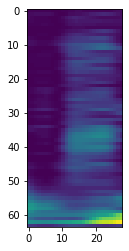

In [ ]:
plt.imshow(train_loader.dataset[10][0][0])

## Encode

In [ ]:
def plot_spikes_2d(fig, z):
    T = z.shape[0]
    C = z.shape[1]

    fig.set_size_inches(10,8)
    for c in range(C):
        ax = fig.add_subplot(1, C, c+1, projection='3d')
        s = z[:,c].detach().to_sparse().coalesce()

        ax.invert_yaxis()
        ax.invert_zaxis()
        ax.set_xlim([0,T])
        ax.set_xlabel('time [ms]')
        ax.set_ylabel('spectrogram time')
        ax.set_zlabel('spectrogram Hz')
        ax.scatter(s.indices()[0], s.indices()[2], s.indices()[1], s=1.0, c=s.values())

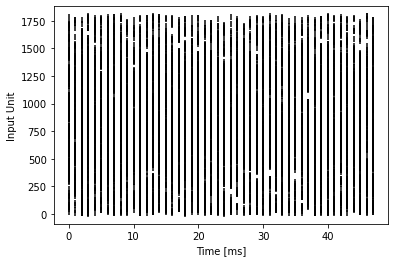

In [ ]:
example_encoder = PoissonEncoder(T)


example_input = example_encoder(img[0])
example_spikes = example_input.reshape(T,img.shape[1]*img.shape[2]).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker='|', color='black')
plt.ylabel('Input Unit')
plt.xlabel('Time [ms]')
plt.show()

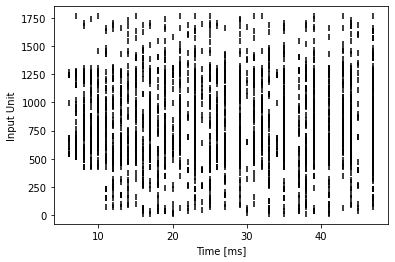

In [ ]:
example_encoder = ConstantCurrentLIFEncoder(T)

example_input = example_encoder(img[0])
example_spikes = example_input.reshape(T,img.shape[1]*img.shape[2]).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker='|', color='black')
plt.ylabel('Input Unit')
plt.xlabel('Time [ms]')
plt.show()

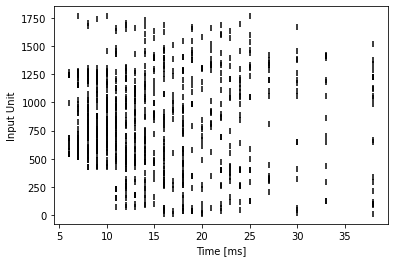

In [ ]:
example_encoder = SpikeLatencyLIFEncoder(T)

example_input = example_encoder(img[0])
example_spikes = example_input.reshape(T,img.shape[1]*img.shape[2]).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker='|', color='black')
plt.ylabel('Input Unit')
plt.xlabel('Time [ms]')
plt.show()

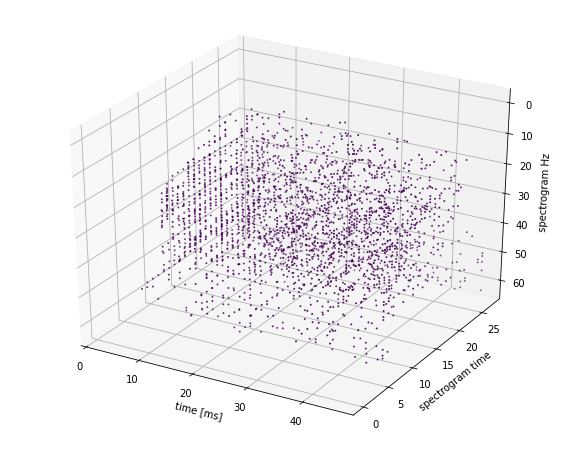

In [ ]:
example_encoder = ConstantCurrentLIFEncoder(T)

example_input = example_encoder(img[0].reshape((1, img.shape[1], img.shape[2])))


fig = plt.figure()

plot_spikes_2d(fig, example_input)

## Convolutional Networks


### CNNs

In [ ]:
class CNN(nn.Module):

  def __init__(self): 
         super(CNN, self).__init__() 
         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)

         self.convlayer1 = nn.Sequential( 
                              nn.Conv2d(32, 64, kernel_size=3, padding=1), 
                              nn.MaxPool2d(kernel_size=2)
                              ) 
         
         self.convlayer2 = nn.Sequential( 
                              nn.Conv2d(64, 96, kernel_size=3, padding=1), 
                              nn.MaxPool2d(kernel_size=2)
                              ) 
         
         self.fclayer1 = nn.Sequential( 
                              nn.Linear(6720, 4096) , 
                              nn.Dropout(0.2) 
                              ) 
         
         self.fclayer2 = nn.Sequential( 
                              nn.Linear(4096, 2048) , 
                              nn.Dropout(0.2) 
                              ) 
            

         self.out = nn.Linear(2048, 22)

  def forward(self, x): 
         out = self.conv1(x) 
         out = self.convlayer1(out) 
         out = self.convlayer2(out) 
         out = out.reshape(out.size(0), -1) 
         #print(out.shape)

         out = self.fclayer1(out) 
         out = self.fclayer2(out) 

         return self.out(out)


In [ ]:
class CNN2(nn.Module):

  def __init__(self): 
         super(CNN2, self).__init__() 


         self.conv1 = nn.Sequential( 
                              nn.Conv2d(3, 64, kernel_size=3), 
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2)
                              ) 
         
         
         self.conv2 = nn.Sequential( 
                              nn.Conv2d(64, 96, kernel_size=3), 
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2)
                              ) 
         
         self.conv3 = nn.Sequential( 
                              nn.Conv2d(96, 128, kernel_size=3), 
                              nn.ReLU(),
                              #nn.MaxPool2d(kernel_size=2)
                              ) 
         

         self.drop_out = nn.Dropout() 

         self.fclayer1 = nn.Linear(2048, 768)


        

         self.out = nn.Linear(768, 10)

  def forward(self, x): 
         out = self.conv1(x) 

         out = self.conv2(out) 

         out = self.conv3(out) 

         out = out.reshape(out.size(0), -1) 
         out = self.drop_out(out) 
         #print(out.shape)

         out = self.fclayer1(out) 


         return self.out(out)


### SNNs

In [ ]:
class Model(nn.Module):
    def __init__(self, encoder, snn, decoder):
        super(Model, self).__init__()
        self.encoder = encoder
        self.snn     = snn
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.snn(x)
        log_p_y = self.decoder(x)
        return log_p_y

In [ ]:
class SCNN(nn.Module):
    def __init__(
        self,  num_channels=1, classes = 10, 
        input_size=(28, 28), kernel_size = 3, 
        method="super", alpha=100, 
    ):
        super(SCNN, self).__init__()

        #### -- ####
        self.classes = classes
        self.lif_param = LIFParameters(method=method, alpha=alpha)
        self.features =  torch.tensor(input_size).int()
        self.max_pool2d = torch.nn.MaxPool2d(2)

        self.features2 = None


        print(self.features)

        #### Conv2D ####
        self.conv1 = torch.nn.Conv2d(num_channels, 64, kernel_size, 1)
        self.lif0 = LIFCell(p=LIFParameters(method=method, alpha=alpha))

        #self.features =   (self.features - (kernel_size - 1) ).int()

        #        MaxPool2d(2)
        self.features =   ((self.features -(kernel_size - 1) - 2)/2 + 1).short()
        self.features1 = self.features
        print(self.features)


        self.conv2 = torch.nn.Conv2d(self.conv1.out_channels, 96, kernel_size, 1)
        self.lif1 = LIFCell(p=LIFParameters(method=method, alpha=alpha))

        #self.features =   (self.features - (kernel_size - 1) ).int()

        #        MaxPool2d(2)
        self.features =   ((self.features -(kernel_size - 1) - 2)/2 + 1).short()
        self.features2 = self.features
        print(self.features)


        #### FC ####
        self.features = self.features[0] * self.features[1] * self.conv2.out_channels

        self.fc1 = torch.nn.Linear(self.features, int(self.features/4))
        self.lif2 = LIFCell(p=LIFParameters(method=method, alpha=alpha))

        #### Out ####
        self.out = LILinearCell(int(self.features/4), self.classes)

    def forward(self, x):
        seq_length = x.shape[0]
        batch_size = x.shape[1]
        
        # specify the initial states
        s0 = s1 = s2 = s3 = s4 = so = None

        voltages = torch.zeros(
            seq_length, batch_size, self.classes, device=x.device, dtype=x.dtype
        )


        self.z_tmp_1 = torch.zeros(
            seq_length, batch_size, self.conv1.out_channels, self.features1[0], self.features1[1], device=x.device, dtype=x.dtype
        ) 


        self.z_tmp_2 = torch.zeros(
            seq_length, batch_size, self.conv2.out_channels, self.features2[0], self.features2[1], device=x.device, dtype=x.dtype
        ) 


        self.z_tmp_fc = torch.zeros(
            seq_length, batch_size, self.fc1.out_features, device=x.device, dtype=x.dtype
        )         
        for ts in range(seq_length):

            z, s0 = self.lif0(10*self.conv1(x[ts, :]), s0)
            z = self.max_pool2d(z)

            self.z_tmp_1[ts, ...] = z 

            z, s1 = self.lif1(self.conv2(z), s1)
            z = self.max_pool2d(z)

            self.z_tmp_2[ts, ...] = z


            z = z.view(-1, self.features)


            z, s3 = self.lif2(self.fc1(z), s3)

            self.z_tmp_fc[ts, ...] = z



            voltages[ts, :, :], so = self.out(z, so)


        return voltages

In [ ]:
def decode(x):
    x, _ = torch.max(x, 0)
    return F.log_softmax(x)

## Train test

In [ ]:
L_acc  = []
L_loss = []

In [ ]:
def evalute(model, test_loader):
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for img, target in tqdm(test_loader):
          
            out = model(img.to(DEVICE))
            
            pred = out.max(1)[1].detach().cpu().numpy()
            target = target.cpu().numpy()
            correct += (pred==target).sum()
            total += len(target)


    return 100*correct / total

In [ ]:
def train(model, train_loader, optimizer):
      model.train()
      for img, target in tqdm(train_loader):
          img, target = img.to(DEVICE), target.to(DEVICE)

          optimizer.zero_grad()

          out = model(img)

          loss = F.nll_loss(out, target)
          
          loss.backward()

          optimizer.step()

      return loss.item() 

In [ ]:
def train_test_loop(model, train_loader, test_loader, opt = 'SGD', EPOCH = 1, lr = 0.01, momentum=0.9 ):
    print('Train model')
    
    if opt == 'SGD':
      optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=1e-4)
    elif opt == 'Adam':
      optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
      print('Unknown optim', opt)


    model.to(DEVICE)

    best_acc = evalute(model, test_loader)
    print('\nAccuracy now: ', best_acc)
    L_acc.append(best_acc)
    
    for epoch in range(1,EPOCH+1):
        print("\nEpoch %d/%d"%(epoch, EPOCH))

        loss = train(model, train_loader, optimizer)
        L_loss.append(loss)
        
        acc = evalute(model, test_loader)
        L_acc.append(acc)
        
        print("Accuracy: ", acc)

        if best_acc < acc:
          print('Save', best_acc,'-->', acc)
          torch.save( model, './checkpoints/snn timit.pth')
          best_acc = acc
          
        print()

    model = torch.load('./checkpoints/snn timit.pth')
    print("\nBest Acc=%.4f"%(best_acc))

## Train test loop

In [ ]:
model = Model(
    encoder= ConstantCurrentLIFEncoder(T),
    snn=SCNN(num_channels = img.shape[0], classes = len(classes), input_size = img[0].shape),
    decoder=decode
).to(DEVICE)

model

tensor([64, 28], dtype=torch.int32)
tensor([31, 13], dtype=torch.int16)
tensor([14,  5], dtype=torch.int16)


Model(
  (encoder): ConstantCurrentLIFEncoder()
  (snn): SCNN(
    (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (lif0): LIFCell(p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=100), dt=0.001)
    (conv2): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (lif1): LIFCell(p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=100), dt=0.001)
    (fc1): Linear(in_features=6720, out_features=1680, bias=True)
    (lif2): LIFCell(p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=100), dt=0.001)
    (out): LILinearCell()
  )
)

In [ ]:
train_test_loop(model, train_loader, test_loader, opt = 'Adam', EPOCH = 10, lr = LR/2)

Train model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until




Accuracy now:  2.7853525516166733

Epoch 1/10



Accuracy:  51.88936501753019
Save 2.7853525516166733 --> 51.88936501753019


Epoch 2/10



Accuracy:  57.14842228282041
Save 51.88936501753019 --> 57.14842228282041


Epoch 3/10



Accuracy:  59.75847292559408
Save 57.14842228282041 --> 59.75847292559408


Epoch 4/10



Accuracy:  66.20568757304247
Save 59.75847292559408 --> 66.20568757304247


Epoch 5/10



Accuracy:  66.73159329957149
Save 66.20568757304247 --> 66.73159329957149


Epoch 6/10



Accuracy:  68.25087650954421
Save 66.73159329957149 --> 68.25087650954421


Epoch 7/10



Accuracy:  70.08180755746007
Save 68.25087650954421 --> 70.08180755746007


Epoch 8/10



Accuracy:  69.77015971951694


Epoch 9/10



Accuracy:  71.40631086871835
Save 70.08180755746007 --> 71.40631086871835


Epoch 10/10


KeyboardInterrupt: ignored

In [ ]:
train_test_loop(model, train_loader, test_loader, opt = 'Adam', EPOCH = 5, lr = LR/5)

Train model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until




Accuracy now:  70.68562524347487

Epoch 1/5



Accuracy:  74.13322945072069
Save 70.68562524347487 --> 74.13322945072069


Epoch 2/5



Accuracy:  73.7047136735489


Epoch 3/5



Accuracy:  74.26957537982081
Save 74.13322945072069 --> 74.26957537982081


Epoch 4/5



Accuracy:  74.32800934943513
Save 74.26957537982081 --> 74.32800934943513


Epoch 5/5



Accuracy:  72.57499026100507


Best Acc=74.3280


In [ ]:
L_loss

[1.369818925857544,
 1.3205050230026245,
 1.6200942993164062,
 1.162612795829773,
 0.9056631326675415,
 0.8696805238723755,
 0.6926325559616089,
 0.865661084651947,
 0.8883693218231201,
 0.4466322064399719,
 0.6171543598175049,
 0.39186519384384155,
 0.3299749791622162,
 0.3863859176635742]

In [ ]:
train_test_loop(model, train_loader, test_loader, opt = 'Adam', EPOCH = 5, lr = LR/10)

Train model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until




Accuracy now:  72.57499026100507

Epoch 1/5



Accuracy:  74.28905336969225
Save 72.57499026100507 --> 74.28905336969225


Epoch 2/5



Accuracy:  74.77600311647838
Save 74.28905336969225 --> 74.77600311647838


Epoch 3/5



Accuracy:  75.22399688352162
Save 74.77600311647838 --> 75.22399688352162


Epoch 4/5



Accuracy:  75.14608492403583


Epoch 5/5



Accuracy:  75.5161667315933
Save 75.22399688352162 --> 75.5161667315933


Best Acc=75.5162


In [ ]:
train_test_loop(model, train_loader, test_loader, opt = 'Adam', EPOCH = 5, lr = LR/15)

Train model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until




Accuracy now:  75.5161667315933

Epoch 1/5



Accuracy:  75.02921698480716


Epoch 2/5



Accuracy:  75.86677054927931
Save 75.5161667315933 --> 75.86677054927931


Epoch 3/5



Accuracy:  75.65251266069342


Epoch 4/5



Accuracy:  75.1266069341644


Epoch 5/5



Accuracy:  75.37982080249319


Best Acc=75.8668


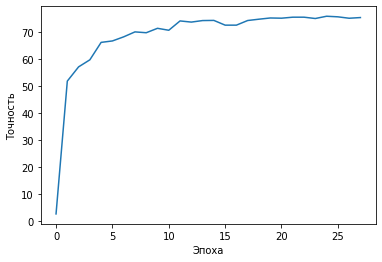

In [ ]:
plt.xlabel("Эпоха")
plt.ylabel("Точность")
plt.plot(L_acc)

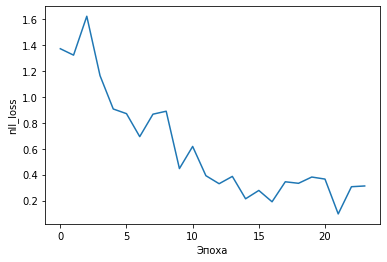

In [ ]:
plt.xlabel("Эпоха")
plt.ylabel("nll_loss")
plt.plot(L_loss)

In [ ]:
model = torch.load('./checkpoints/snn timit.pth')

In [ ]:
evalute(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


75.86677054927931

In [ ]:
evalute(model, train_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


91.00691401304898

### Quant

In [ ]:
def sign(x):
  if x == 0: return 0 
  return 1 if x>0 else -1

L = 4

def Quant(weight, levels = 4):
  dev = weight.device
  D = weight.max().item()/(L - 1)
  W = weight.clone().detach().cpu() 
  for k in range(L):
    W.apply_(lambda x: k*D*sign(x) if k < sign(x)*x/D < k+1 else x)

  return W.to(dev)



In [ ]:
model = torch.load('./checkpoints/snn timit.pth')

evalute(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


75.86677054927931

In [ ]:
L = 4

model.snn.conv1.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv1.weight, L))
model.snn.conv2.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv2.weight, L))
model.snn.fc1.weight = torch.nn.parameter.Parameter(Quant(model.snn.fc1.weight, L))
model.snn.out.input_weights = torch.nn.parameter.Parameter(Quant(model.snn.out.input_weights, L))

evalute(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


0.6038176860148032

In [ ]:
model = torch.load('./checkpoints/snn timit.pth')

In [ ]:
L = 5

model.snn.conv1.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv1.weight, L))
model.snn.conv2.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv2.weight, L))
model.snn.fc1.weight = torch.nn.parameter.Parameter(Quant(model.snn.fc1.weight, L))
model.snn.out.input_weights = torch.nn.parameter.Parameter(Quant(model.snn.out.input_weights, L))

evalute(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


6.252434748733931

In [ ]:
model = torch.load('./checkpoints/snn timit.pth')

In [ ]:
L = 6

model.snn.conv1.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv1.weight, L))
model.snn.conv2.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv2.weight, L))
model.snn.fc1.weight = torch.nn.parameter.Parameter(Quant(model.snn.fc1.weight, L))
model.snn.out.input_weights = torch.nn.parameter.Parameter(Quant(model.snn.out.input_weights, L))

evalute(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


10.381768601480328

In [ ]:
model = torch.load('./checkpoints/snn timit.pth')

In [ ]:
L = 8

model.snn.conv1.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv1.weight, L))
model.snn.conv2.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv2.weight, L))
model.snn.fc1.weight = torch.nn.parameter.Parameter(Quant(model.snn.fc1.weight, L))
model.snn.out.input_weights = torch.nn.parameter.Parameter(Quant(model.snn.out.input_weights, L))

evalute(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


12.855473315153876

In [ ]:
model = torch.load('./checkpoints/snn timit.pth')

In [ ]:
L = 16

model.snn.conv1.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv1.weight, L))
model.snn.conv2.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv2.weight, L))
model.snn.fc1.weight = torch.nn.parameter.Parameter(Quant(model.snn.fc1.weight, L))
model.snn.out.input_weights = torch.nn.parameter.Parameter(Quant(model.snn.out.input_weights, L))

evalute(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


55.96026490066225

In [ ]:
model = torch.load('./checkpoints/snn timit.pth')

In [ ]:
L = 32

model.snn.conv1.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv1.weight, L))
model.snn.conv2.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv2.weight, L))
model.snn.fc1.weight = torch.nn.parameter.Parameter(Quant(model.snn.fc1.weight, L))
model.snn.out.input_weights = torch.nn.parameter.Parameter(Quant(model.snn.out.input_weights, L))

evalute(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


71.75691468640436

In [ ]:
model = torch.load('./checkpoints/snn timit.pth')

In [ ]:
L = 64

model.snn.conv1.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv1.weight, L))
model.snn.conv2.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv2.weight, L))
model.snn.fc1.weight = torch.nn.parameter.Parameter(Quant(model.snn.fc1.weight, L))
model.snn.out.input_weights = torch.nn.parameter.Parameter(Quant(model.snn.out.input_weights, L))

evalute(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


73.82158161277756

In [ ]:
model = torch.load('./checkpoints/snn timit.pth')

In [ ]:
L = 128

model.snn.conv1.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv1.weight, L))
model.snn.conv2.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv2.weight, L))
model.snn.fc1.weight = torch.nn.parameter.Parameter(Quant(model.snn.fc1.weight, L))
model.snn.out.input_weights = torch.nn.parameter.Parameter(Quant(model.snn.out.input_weights, L))

evalute(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


75.65251266069342

In [ ]:
model = torch.load('./checkpoints/snn timit.pth')

In [ ]:
L = 256

model.snn.conv1.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv1.weight, L))
model.snn.conv2.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv2.weight, L))
model.snn.fc1.weight = torch.nn.parameter.Parameter(Quant(model.snn.fc1.weight, L))
model.snn.out.input_weights = torch.nn.parameter.Parameter(Quant(model.snn.out.input_weights, L))

evalute(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


75.1266069341644

In [ ]:
model = torch.load('./checkpoints/snn timit.pth')

In [ ]:
L = 512

model.snn.conv1.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv1.weight, L))
model.snn.conv2.weight = torch.nn.parameter.Parameter(Quant(model.snn.conv2.weight, L))
model.snn.fc1.weight = torch.nn.parameter.Parameter(Quant(model.snn.fc1.weight, L))
model.snn.out.input_weights = torch.nn.parameter.Parameter(Quant(model.snn.out.input_weights, L))

evalute(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


75.43825477210751